# Text Summarization & Visualization

## Setup
To prepare your environment, you need to install some packages.

### Install the necessary packages

In [1]:
!pip install "gensim==3.8.3"

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
!pip install watson-developer-cloud

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 248 kB 19.3 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 15.6 MB/s eta 0:00:01
  Created wheel for watson-developer-cloud: filename=watson_developer_cloud-2.10.1-py3-none-any.whl size=252812 sha256=a00504655baa339fdbd8252c8b31545155b381d12e0a9ba9471dd6944639c56e
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/45/68/30/690e59503415433f536c00ef66656a1aa045e927a2ad6ab7fc
Successfully built watson-developer-cloud


In [3]:
!pip install pyldavis

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [4]:
!pip install wordcloud

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [5]:
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
import ibm_boto3
from botocore.client import Config
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import urllib
from bs4 import BeautifulSoup
import requests
import nltk
nltk.download('all')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/wsuser/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/wsuser/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/wsuser/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date

True

## 1. Summarization & keywords extraction

### 1a. Read the Data
Click on Insert to code and then select Insert Credentials as credentials_1

### 1b. Functions to extract files from Cloud Object Storage

In [7]:
cos = ibm_boto3.client('s3',
                    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                    config=Config(signature_version='oauth'),
                    endpoint_url=credentials_1['ENDPOINT'])

def get_file(filename):
    '''Retrieve file from Cloud Object Storage'''
    fileobject = cos.get_object(Bucket=credentials_1['BUCKET'], Key=filename)['Body']
    return fileobject

def load_string(fileobject):
    '''Load the file contents into a Python string'''
    text = fileobject.read()
    return text

### 1c. Get File Contents

In [8]:
text=str(load_string(get_file("Mission_Impossible_6_Review.txt")))

### 1d. Helper functions to extract summary and keywords

In [9]:
'''Get the summary of the text'''

def get_summary(text, pct):
    summary = summarize(text,ratio=pct,split=True)
    return summary

'''Get the keywords of the text'''

def get_keywords(text):
    res = keywords(text, ratio=0.1, words=None, split=False, scores=False, pos_filter=('NN', 'JJ'), lemmatize=False, deacc=False)
    res = res.split('\n')
    return res

'''Tokenize the sentence into words & remove punctuation'''

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def split_sentences(text):
    """ Split text into sentences.
    """
    sentence_delimiters = re.compile(u'[\\[\\]\n.!?]')
    sentences = sentence_delimiters.split(text)
    return sentences

def split_into_tokens(text):
    """ Split text into tokens.
    """
    tokens = nltk.word_tokenize(text)
    return tokens
    
def POS_tagging(text):
    """ Generate Part of speech tagging of the text.
    """
    POSofText = nltk.tag.pos_tag(text)
    return POSofText

def extract_title_text(url):
    page = urllib.request.urlopen(url).read().decode('utf8')
    soup = BeautifulSoup(page,'lxml')
    text = ' '.join(map(lambda p: p.text, soup.find_all('p')))
    return soup.title.text, text

In [10]:
print('Printing Summary')
print('--------------------------')
print(get_summary(text, 0.3))
print ('-------------------------')
print('Printing Keywords')
print('--------------------------')
print(get_keywords(text))

Printing Summary
--------------------------
["The shot is in the movie and it will make you wince because you know the context, but otherwise you don't really notice any difference as the stunt in question is just the latest in a long line of deathdefying activities featuring Cruise.What makes more of an impact on the sixth movie in the series is its connection to the previous movie, Rogue Nation, with the return of the villainous Solomon Lane (played creepily again by Sean Harris) and his nefarious Syndicate, who are again threatening the world.With the addition of Ethan Hunt's former wife Julia (Michelle Monaghan) from the third movie, Fallout is immediately given more depth than previous outings and the stakes feel higher, with Ethan Hunt (Cruise) haunted by his past mistakes.", "At times, even IMAX doesn't feel big enough to contain it.Putting aside the direct connection to the previous movie and the series' first returning director in Christopher McQuarrie, it's pretty much busine

## 2. Visualization

### 2a. Remove punctuation & special characters

In [11]:
import re
my_new_text = re.sub('[^ a-zA-Z0-9]', '', text)

### 2b. Preprocess the text for next steps

In [12]:
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
word_tokens = word_tokenize(str(my_new_text)) 
filtered_sentence = [w for w in word_tokens if not w in stop_words]
normalized = " ".join(lemma.lemmatize(word) for word in filtered_sentence)

### 2c. Create n grams where n is the number of words

In [13]:
from nltk import ngrams
n = 7
total_grams = []
number_of_grams = ngrams(normalized.split(), n)
for grams in number_of_grams:
    total_grams.append(grams)

In [14]:
print(total_grams[:10])

[('bBefore', 'release', 'Mission', 'Impossible', 'Fallout', 'known', 'two'), ('release', 'Mission', 'Impossible', 'Fallout', 'known', 'two', 'thing'), ('Mission', 'Impossible', 'Fallout', 'known', 'two', 'thing', 'fact'), ('Impossible', 'Fallout', 'known', 'two', 'thing', 'fact', 'first'), ('Fallout', 'known', 'two', 'thing', 'fact', 'first', 'direct'), ('known', 'two', 'thing', 'fact', 'first', 'direct', 'sequel'), ('two', 'thing', 'fact', 'first', 'direct', 'sequel', 'series'), ('thing', 'fact', 'first', 'direct', 'sequel', 'series', 'THAT'), ('fact', 'first', 'direct', 'sequel', 'series', 'THAT', 'injury'), ('first', 'direct', 'sequel', 'series', 'THAT', 'injury', 'Tom')]


### 2d. Create the wordcloud visualization on the processed data
To highlight important textual data points & convey crucial information. The more a specific word appears in a source of textual data, the bigger and bolder it appears in the word cloud.

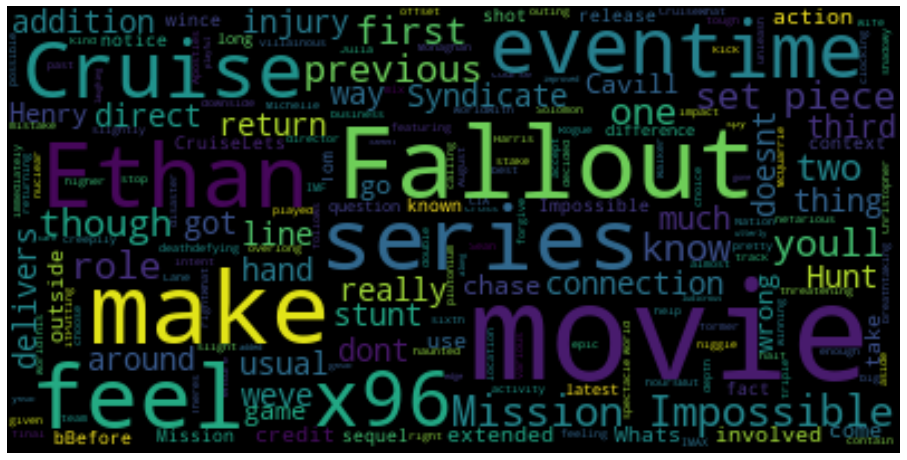

In [15]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=60).generate(normalized)
plt.figure(figsize=(16,12))

'''plot wordcloud in matplotlib'''

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 2e. Analyze the frequency of words in the text. 

In [16]:
count = {}
for w in normalized.split():
    if w in count:
        count[w] += 1
    else:
        count[w] = 1
for word, times in count.items():
    if times > 3:
        print("%s was found %d times" % (word, times))

Mission was found 4 times
Impossible was found 4 times
Fallout was found 6 times
series was found 5 times
get was found 4 times
movie was found 12 times
make was found 6 times
Ethan was found 4 times
feel was found 5 times
Cruise was found 4 times
time was found 4 times
even was found 4 times
x96 was found 4 times


### 2f. Create a Dispersion plot
The motivation behind using the Lexical Dispersion Plots was to give us an alternative means of visualising how prevalent  these words are in the text corpus, whether or not there was a clustering pattern that is whether or not a word featured heavily at certain point of the text corpus.

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


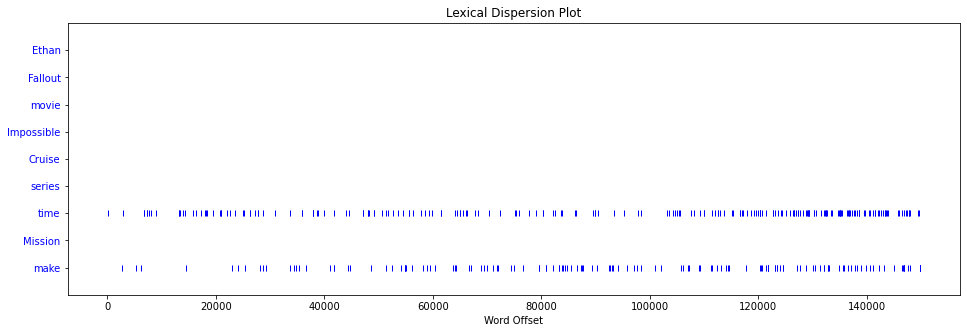

In [17]:
from nltk.book import text4 as content
plt.figure(figsize=(16,5))
topics = ['Ethan', 'Fallout','movie', 'Impossible', 'Cruise', 'series', 'time', 'Mission', 'make']
content.dispersion_plot(topics)

## 3. Topic Modelling

### 3a. Start the preprocessing for Topic Modelling

Topic Modelling is an approach for finding topics in large amounts of text. Topic modeling is great for document clustering, information retrieval from unstructured text, and feature selection.
 
Topic Modeling with Latent Dirichlet Allocation technique.

Why Latent Dirichlet Allocation? This technique can create model which can be generalized easily on any new text corpus and help us in identifying the important topics from the corpus. 

Some of the advantages are :

Training documents may come in sequentially, no random access required.

Runs in constant memory w.r.t. the number of documents: size of the training corpus does not affect memory footprint, can process corpora larger than RAM.

Is distributed & makes use of a cluster of machines, if available, to speed up model estimation.

In [18]:
import gensim
from gensim import corpora

tokenized_sents = list(sent_to_words(filtered_sentence))

# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(tokenized_sents)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_sents]

### 3b. Creating the object for LDA model & train the model

In [19]:
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix by selecting minimum parameters required.
ldamodel = Lda(doc_term_matrix, num_topics=2, id2word = dictionary, passes=100)

### 3c. Extract two topics with twenty words in each topic

In [20]:
print(ldamodel.print_topics(num_topics=2, num_words=20))

[(0, '0.023*"movie" + 0.013*"series" + 0.013*"mission" + 0.011*"cruise" + 0.011*"theres" + 0.011*"feel" + 0.011*"ethan" + 0.009*"previous" + 0.009*"though" + 0.009*"one" + 0.009*"like" + 0.009*"movies" + 0.009*"two" + 0.006*"wrong" + 0.006*"usual" + 0.006*"stunt" + 0.006*"go" + 0.006*"connection" + 0.006*"games" + 0.006*"way"'), (1, '0.017*"fallout" + 0.015*"impossible" + 0.012*"makes" + 0.012*"get" + 0.012*"even" + 0.009*"set" + 0.009*"role" + 0.009*"first" + 0.009*"youll" + 0.007*"involved" + 0.007*"pieces" + 0.007*"come" + 0.007*"addition" + 0.007*"its" + 0.007*"make" + 0.007*"really" + 0.007*"whats" + 0.007*"dont" + 0.007*"time" + 0.007*"outside"')]


### 3d. Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 

In [21]:
'''Compute Perplexity'''

# a measure of how good the model is. lower the better.

print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix))

'''Compute Coherence Score'''

coherence_model_lda = CoherenceModel(model=ldamodel, texts=tokenized_sents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.644079856734302

Coherence Score:  0.8622156285946678


#### Coherence score is 'higher the better' metric and given the score of 0.86 we can be assured that we have selected the right number of topics for this corpus.

In [23]:
'''Visualize the topics'''
# pyLDAvis tool to visualize the fit of our LDA model across topics and their top words. 
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
0      0.083938  0.0       1        1  51.78048
1     -0.083938  0.0       2        1  48.21952, topic_info=           Term      Freq     Total Category  logprob  loglift
21        movie  5.000000  5.000000  Default  30.0000  30.0000
4       fallout  3.000000  3.000000  Default  29.0000  29.0000
3    impossible  3.000000  3.000000  Default  28.0000  28.0000
12       series  3.000000  3.000000  Default  27.0000  27.0000
2       mission  3.000000  3.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
107       times  1.410273  1.703386   Topic2  -5.0181   0.5406
239      action  1.410272  1.703386   Topic2  -5.0181   0.5406
58    worldwith  0.841102  1.134650   Topic2  -5.5349   0.4300
41       impact  0.841102  1.134650   Topic2  -5.5349   0.4300
251     realism  0.841102  1.134650   Topic2  -5.5349   0.4300

[91 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
239       2  0.587066     action
59        2  0.587066   addition
141       1  0.590684     around
151       1  0.590684     cavill
237       2  0.587066       come
...     ...       ...        ...
103       2  0.587066       weve
254       2  0.587066      whats
58        2  0.881329  worldwith
161       1  0.590684      wrong
96        2  0.880235      youll

[61 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

#### We can observe that our LDA model has captured the prominent keywords under two topics in the text corpus which will give us a good understanding of what the text corpus is about. We can do further analysis by using this information to generate recommendations & classify the text for user profiling or push notifications. 

## In the next section, we will see how we can summarize and visualize news article!

### 1. Summarization & keywords extraction

In [24]:
'''Extract the first article of the news feed'''

url = urllib.request.urlopen('http://feeds.bbci.co.uk/news/rss.xml').read()
feed = BeautifulSoup(url.decode('utf8'),'lxml')
urls_to_summarize = list(map(lambda p: p.text, feed.find_all('guid')))
for article_url in urls_to_summarize[:1]:
    title, text = extract_title_text(article_url)
    print ('-------------------------------------------------------------------------------------------------------------------')
    print('Printing title & text')
    print('-----------------------')
    print (title, text)
    print ('-------------------------------------------------------------------------------------------------------------------')
    print('Printing title & summary')
    print('--------------------------')
    print (title)
    for s in get_summary(text, 0.2):
        print((s))
    print ('-------------------------------------------------------------------------------------------------------------------')
    print('Printing Keywords')
    print('--------------------------')
    for i in get_keywords(text):
        print((i))

-------------------------------------------------------------------------------------------------------------------
Printing title & text
-----------------------
Ballymurphy Inquest: Coroner finds 10 victims were innocent - BBC News Ten people killed in west Belfast almost 50 years ago in the wake of an Army operation were "entirely innocent", an inquest has found. The inquest, which began in November 2018, examined the deaths in and around the Ballymurphy area of west Belfast in August 1971.  The shootings happened after an operation in which paramilitary suspects were detained without trial. Victims included a priest trying to help the wounded and a mother of eight. Nine of the 10 victims were killed by the Army, the coroner said.  The coroner could not definitively say who shot the tenth victim, John McKerr. "What is very clear, is that all of the deceased in the series of inquests were entirely innocent of wrongdoing on the day in question," said the Coroner, Mrs Justice Keegan.   

In [25]:
_title = []
_text = []
_summarized_text = []

for article_url in urls_to_summarize[:1]:
    title, text = extract_title_text(article_url)
    new_text = get_summary(text, 0.3)
    _title.append(title), _text.append(text), _summarized_text.append(new_text)

In [26]:
article_text = _text[0]
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
word_tokens = word_tokenize(str(article_text)) 
filtered_sentence = [w for w in word_tokens if not w in stop_words]
normalized = " ".join(lemma.lemmatize(word) for word in filtered_sentence)

### 2. Visualization

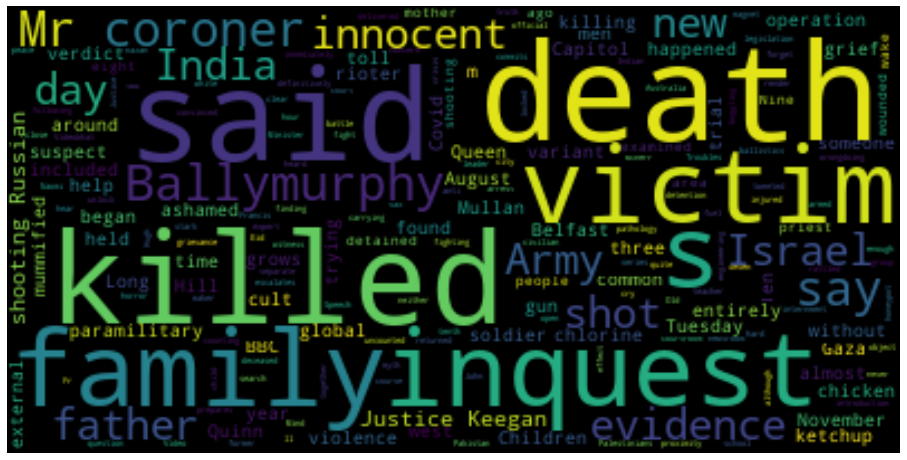

In [27]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=60).generate(normalized)
plt.figure(figsize=(16,12))

'''plot wordcloud in matplotlib'''

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

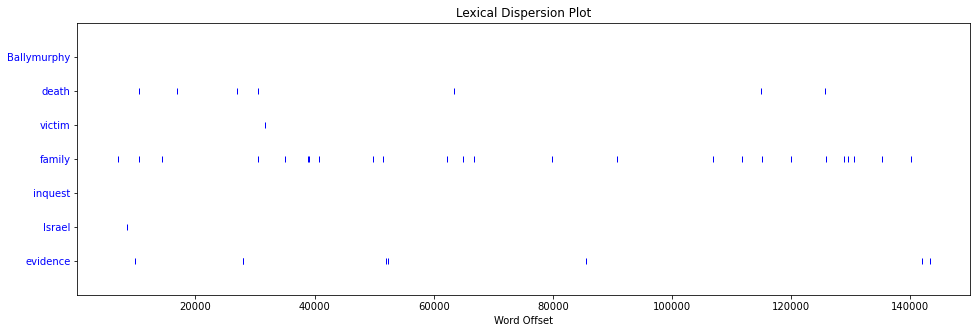

In [28]:
from nltk.book import text4 as content
plt.figure(figsize=(16,5))
topics = ['Ballymurphy', 'death','victim', 'family', 'inquest', 'Israel', 'evidence']
content.dispersion_plot(topics)

We can observe that 'death' is being discussed throughout the article along with references to border, deal & cabinet. 

### 3. Create Topic Model

In [29]:
tokenized_sents = list(sent_to_words(filtered_sentence))

# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(tokenized_sents)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_sents]

In [30]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=2, id2word = dictionary, passes=100)

# Print the model output
print(ldamodel.print_topics(num_topics=2, num_words=20))

[(0, '0.021*"killed" + 0.014*"ballymurphy" + 0.014*"victims" + 0.014*"justice" + 0.011*"israel" + 0.011*"family" + 0.011*"deaths" + 0.011*"who" + 0.011*"new" + 0.011*"shooting" + 0.011*"evidence" + 0.011*"russian" + 0.011*"she" + 0.011*"shot" + 0.008*"gaza" + 0.008*"belfast" + 0.008*"says" + 0.008*"concern" + 0.008*"covid" + 0.008*"say"'), (1, '0.035*"the" + 0.020*"said" + 0.017*"death" + 0.017*"coroner" + 0.011*"innocent" + 0.011*"india" + 0.011*"children" + 0.011*"keegan" + 0.011*"mrs" + 0.011*"inquests" + 0.011*"army" + 0.011*"father" + 0.008*"variant" + 0.008*"escalates" + 0.008*"killings" + 0.008*"included" + 0.008*"hill" + 0.008*"could" + 0.008*"toll" + 0.008*"years"')]


In [31]:
'''Compute Perplexity'''

# a measure of how good the model is. Lower the better.
print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix))

'''Compute Coherence Score'''

coherence_model_lda = CoherenceModel(model=ldamodel, texts=tokenized_sents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.24881229839046

Coherence Score:  0.8567753586930299


### 4. Visualize the topics from the model

pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

In [32]:
'''Visualize the topics'''
# pyLDAvis tool to visualize the fit of our LDA model across topics and their top words. 
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.099419  0.0       1        1  50.789051
0     -0.099419  0.0       2        1  49.210949, topic_info=        Term      Freq     Total Category  logprob  loglift
15       the  7.000000  7.000000  Default   30.000  30.0000
2     killed  4.000000  4.000000  Default   29.000  29.0000
41      said  4.000000  4.000000  Default   28.000  28.0000
156    death  3.000000  3.000000  Default   27.000  27.0000
40   coroner  3.000000  3.000000  Default   26.000  26.0000
..       ...       ...       ...      ...      ...      ...
16     began  1.516703  1.831452   Topic2   -4.838   0.5205
44       say  1.516703  1.831452   Topic2   -4.838   0.5205
50      what  1.516703  1.831452   Topic2   -4.838   0.5205
69     three  1.516703  1.831453   Topic2   -4.838   0.5205
118     time  1.516703  1.831452   Topic2   -4.838   0.5205

[98 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
9         1  0.826468         army
20        2  1.092029       around
174       2  1.092030      ashamed
21        2  0.981934  ballymurphy
243       1  0.550667          bbc
...     ...       ...          ...
3         1  0.550667         west
50        2  1.092029         what
133       2  0.818557          who
29        1  0.550667      without
6         1  0.550667        years

[68 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

### We have seen how to summarize & visualize a document as well as a news article to get quick information about the data. This methodology can be applied to lot of usecases to extract insights from unstructured data.